# 프로젝트: 고양이 수염 카메라 필터

## 1. 라이브러리 불러오기 & 경로 설정

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

print("cv2 version:", cv2.__version__)
print("dlib version:", dlib.__version__)
print("🐈🧶") # 코드 잘 잘동 중!

cv2 version: 4.12.0
dlib version: 19.24.6
🐈🧶


In [2]:
# 파일 경로
home_dir = '/content/drive/MyDrive/aiffel_rs_16/Ex01/'

# 기준 이미지
my_image_path = os.path.join(home_dir, 'itsme.png')

# 시험용 이미지
my_image_path_test1 = os.path.join(home_dir, 'itsme2.png')
my_image_path_test2 = os.path.join(home_dir, 'itsme3.png')
my_image_path_test3 = os.path.join(home_dir, 'freedobby.png')
my_image_path_test4 = os.path.join(home_dir, 'draco.png')

# 고양이 수염 스티커
sticker_path = os.path.join(home_dir, 'cat_whiskers.png')

# 랜드마크 모델
landmark_model_path = os.path.join(home_dir, 'shape_predictor_68_face_landmarks.dat')

## 2. 공통 함수 정의

In [3]:
def load_image(path):
    """
    이미지 로드 및 초기화 함수
    - OpenCV BGR 상태로 읽기
    - img_show 초기화
    """
    img_bgr = cv2.imread(path)           # BGR로 로드
    img_show = img_bgr.copy()            # 기준 이미지 초기화
    return img_bgr, img_show

In [4]:
def show_image(img, title="", figsize=(3,3), is_rgb=False):
    """
    이미지 시각화 함수
    - is_rgb=True면 RGB로 변환 후 출력
    """
    plt.figure(figsize=figsize)

    if is_rgb:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img)

    print(title)
    plt.axis("off")
    plt.show()
    print("\n")

## 3. 이미지 로드

원본 BGR 이미지


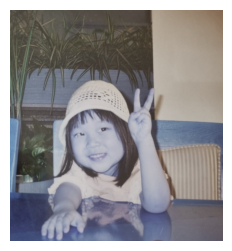



RGB 변환 이미지


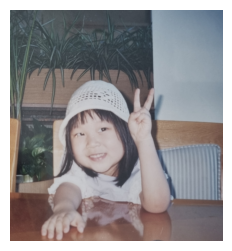

In [5]:
img_bgr, img_show = load_image(my_image_path)  # 이미지 불러오기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # 변환 이미지

# 원본 BGR 이미지 표시
show_image(img_bgr, title="원본 BGR 이미지")

# RGB 변환해서 표시
show_image(img_bgr, title="RGB 변환 이미지", is_rgb=True)

## 4. 얼굴 탐지 및 랜드마크 검출

### 4-1. 얼굴 탐지

In [6]:
def detect_face_and_draw_bbox(img_rgb, box_color=(0, 255, 0), thickness=3):
    """
    얼굴 탐지 + bounding box 시각화 함수
    - img_rgb: RGB 이미지
    - detector: dlib 얼굴 detector
    - box_color: bounding box 색상 (BGR)
    - thickness: 선 두께
    Returns:
        dlib_rects: 얼굴 영역 리스트
        img_out: bounding box가 그려진 이미지 (BGR)
    """

    # detector 초기화: dlib 기본 frontal face detector 생성
    detector = dlib.get_frontal_face_detector()

    # 이미지 복사본 생성: 원본 손상 방지
    img_out = img_rgb.copy()

    # 얼굴 탐지: 이미지와 피라미드 수치 입력
    dlib_rects = detector(img_rgb, 1)

    # 탐지된 각 얼굴 영역에 대해 바운딩 박스 그리기
    for rect in dlib_rects:
        # 좌표 추출
        l = rect.left()    # 왼쪽
        t = rect.top()     # 위쪽
        r = rect.right()   # 오른쪽
        b = rect.bottom()  # 아래쪽

        cv2.rectangle(img_out, (rect.left(), rect.top()), (rect.right(), rect.bottom()),
                        box_color, thickness)

    return dlib_rects, img_out

Bounding Box 얼굴 탐지


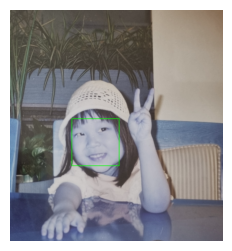

In [7]:
# detect_face_and_draw_bbox 실행
dlib_rects, img_show = detect_face_and_draw_bbox(img_rgb)

# 결과 확인 (RGB로 변환 후)
show_image(img_show, title="Bounding Box 얼굴 탐지", is_rgb=True)

### 4-2. 랜드마크 검출

In [8]:
def detect_landmarks(img_rgb, dlib_rects, predictor):
    """
    얼굴 랜드마크 추출 및 시각화 함수
    - img_rgb: RGB 이미지 (numpy array)
    - dlib_rects: detect_faces나 detector_hog에서 반환된 얼굴 박스 리스트
    - predictor: dlib.shape_predictor 모델
    Returns:
        list_landmarks: 각 얼굴별 랜드마크 좌표 리스트
        img_out: 랜드마크가 그려진 이미지 (복사본)
    """
    # 출력용 이미지 복사본 생성
    img_out = img_rgb.copy()

    # 얼굴별 랜드마크 좌표를 저장할 리스트 초기화
    list_landmarks = []

    # 얼굴 영역 박스마다 랜드마크 추출
    for rect in dlib_rects:
        # dlib predictor로 랜드마크 검출
        points = predictor(img_rgb, rect)

        # dlib.full_object_detection -> (x, y) 좌표 리스트로 변환
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))

        # 각 얼굴별 좌표 리스트를 최종 리스트에 추가
        list_landmarks.append(list_points)

        # 랜드마크를 이미지 위에 그리기
        for point in list_points:
            cv2.circle(img_out, point, 5, (255, 255, 0), -1)  # 반지름 3, 색상 RGB(0,255,255), 채워진 원

    return list_landmarks, img_out

바운딩 박스 + 랜드마크 검출


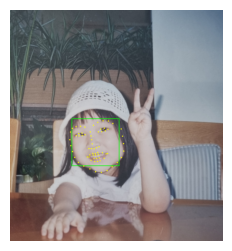

In [9]:
# 바운딩 박스가 그려진 이미지
img_with_boxes = img_show.copy()  # img_show: detect_faces_and_draw에서 반환된 이미지

# dlib predictor 모델 준비
landmark_predictor = dlib.shape_predictor(landmark_model_path) # 용량 문제로 함수 밖에서 모델 선언

# 랜드마크 검출
list_landmarks, img_landmarks = detect_landmarks(img_with_boxes, dlib_rects, landmark_predictor)

# 시각화
show_image(img_landmarks, title="바운딩 박스 + 랜드마크 검출")

## 5. 고양이 수염 스티커 합성

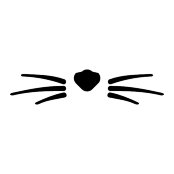

In [10]:
# 스티커 로드
img_sticker = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)

if img_sticker is None:
    raise ValueError("스티커 이미지 로드 실패")

plt.figure(figsize=(2, 2))
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGRA2RGBA))
plt.axis('off')
plt.show()

In [11]:
def apply_cat_whiskers(img, dlib_rects, list_landmarks, img_sticker):
    """
    얼굴에 고양이 수염 스티커 합성
    - img: 원본 이미지 (BGR)
    - dlib_rects: 얼굴 영역 리스트
    - list_landmarks: 랜드마크 좌표 리스트
    - img_sticker: 스티커 이미지 (투명 배경 지원)

    Returns:
        img_out: 스티커 합성된 이미지
    """
    img_out = img.copy()
    img_h, img_w = img_out.shape[:2]

    for rect, landmark in zip(dlib_rects, list_landmarks):
        # 기준 좌표: 코 끝 (33번)
        nose_x, nose_y = landmark[33]

        # 얼굴 크기
        face_w, face_h = rect.width(), rect.height()

        # 스티커 크기
        sticker_w = int(face_w * 0.6)
        sticker_h = int(sticker_w * img_sticker.shape[0] / img_sticker.shape[1])
        sticker_resized = cv2.resize(img_sticker, (sticker_w, sticker_h))

        # 얼굴 기울기 계산 (눈 랜드마크 이용)
        left_eye = landmark[36:42]
        right_eye = landmark[42:48]
        lx = sum(p[0] for p in left_eye) / len(left_eye)
        ly = sum(p[1] for p in left_eye) / len(left_eye)
        rx = sum(p[0] for p in right_eye) / len(right_eye)
        ry = sum(p[1] for p in right_eye) / len(right_eye)
        dx, dy = rx - lx, ry - ly
        angle = -np.degrees(np.arctan2(dy, dx))  # 얼굴 각도 보정

        # 스티커 회전
        center = (sticker_w // 2, sticker_h // 2)
        rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
        sticker_rotated = cv2.warpAffine(
            sticker_resized, rot_mat, (sticker_w, sticker_h),
            borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0)
        )

        # 스티커 위치 계산 (코 중심)
        x = max(0, min(nose_x - sticker_w // 2, img_w - sticker_w))
        y = max(0, min(nose_y - sticker_h // 2, img_h - sticker_h))

        # 알파 채널 분리
        sticker_bgr = sticker_rotated[:, :, :3]
        sticker_alpha = sticker_rotated[:, :, 3] / 255.0

        # ROI 추출
        roi = img_out[y:y+sticker_h, x:x+sticker_w]

        # 알파 블렌딩
        for c in range(3):
            roi[:, :, c] = sticker_alpha * sticker_bgr[:, :, c] + (1 - sticker_alpha) * roi[:, :, c]

        img_out[y:y+sticker_h, x:x+sticker_w] = roi

    return img_out

🐈 고양이 수염 합성 완료


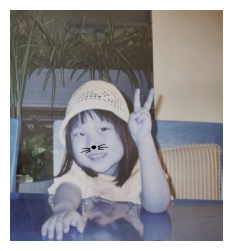

In [12]:
# 스티커 합성
img_with_whiskers = apply_cat_whiskers(img_bgr, dlib_rects, list_landmarks, img_sticker)
show_image(img_with_whiskers, title="🐈 고양이 수염 합성 완료")

## 6. 시험

In [13]:
# 테스트용 이미지 목록
test_image_paths = [
    my_image_path_test1,
    my_image_path_test2
]

In [14]:
def test_apply_cat_whiskers(image_paths, detector, predictor, img_sticker):
    """
    여러 이미지에 대해 고양이 수염 합성 테스트
    """

    for idx, path in enumerate(image_paths):
        print(f"\n🐾 Test {idx+1}")

        # 1. 이미지 로드
        img_bgr = cv2.imread(path)
        if img_bgr is None:
            print("이미지 로드 실패")
            continue

        # 2. RGB 변환
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # 3. 얼굴 감지
        dlib_rects = detector(img_rgb, 1)
        if len(dlib_rects) == 0:
            print("얼굴을 찾지 못했습니다")
            show_image(img_rgb, title="얼굴 없음")
            continue

        # 4. 랜드마크 추출
        list_landmarks = []
        for rect in dlib_rects:
            points = predictor(img_rgb, rect)
            list_points = [(p.x, p.y) for p in points.parts()]
            list_landmarks.append(list_points)

        # 5. 수염 합성
        try:
            img_result = apply_cat_whiskers(
                img_bgr,
                dlib_rects,
                list_landmarks,
                img_sticker
            )
        except Exception as e:
            print("수염 합성 실패:", e)
            continue

        # 6. 결과 출력
        show_image(
            cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB)
        )

        print("성공! 🐈🧶")


🐾 Test 1



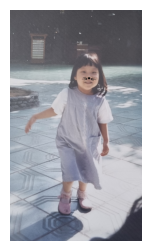



성공! 🐈🧶

🐾 Test 2



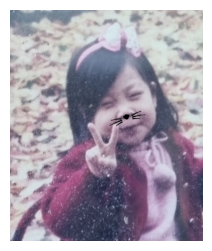



성공! 🐈🧶


In [15]:
# detector 준비
detector = dlib.get_frontal_face_detector()

# 테스트 실행
test_apply_cat_whiskers(
    test_image_paths,
    detector=detector,
    predictor=landmark_predictor, # predictor 위에서 선언
    img_sticker=img_sticker
)

보너스 - 성별이 달라도 종이 달라도 성공할까?

In [16]:
# 보너스 테스트용 이미지 목록
bonus_test_image_paths = [
    my_image_path_test3,
    my_image_path_test4
]


🐾 Test 1
얼굴을 찾지 못했습니다
얼굴 없음


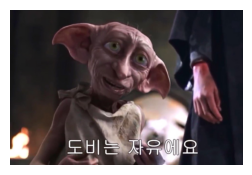




🐾 Test 2



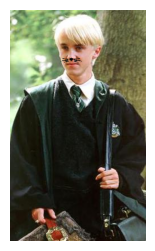



성공! 🐈🧶


In [17]:
# 테스트 실행
test_apply_cat_whiskers(
    bonus_test_image_paths,
    detector=detector,
    predictor=landmark_predictor,
    img_sticker=img_sticker
)

## 정리

- 얼굴이 정면에서 약간 회전되어 있더라도 눈, 코, 입 등 주요 특징점이 명확히 식별 가능하다면, 고양이 수염 스티커가 적절하게 부착되었다고 판단할 수 있다.

- 얼굴 일부가 가려졌을 경우에도 모델의 성능 저하는 미미했으며, 볼 부분이 부분적으로 가려진 정도에서는 탐지 및 합성이 원활히 이루어졌다.

- dlib의 `get_frontal_face_detector()`는 주로 전면 인물 얼굴에 최적화된 알고리즘이므로, 비정형적이고 비인간형 얼굴 특징을 가진 캐릭터(예: 집요정 도비)의 얼굴을 정확히 탐지하지 못했을 가능성이 큰 듯하다.

## 회고

- 캐릭터 등 비인간형 얼굴에서는 dlib의 `get_frontal_face_detector()`와 `shape_predictor`가 성능이 저하되는 점을 확인하며, 이 알고리즘들의 얼굴 검출 적용 범위에 한계가 있음을 알 수 있었다.

- 스티커의 크기와 위치를 동적으로 조정하는 과정에서 예상 외로 시간이 많이 걸려 놀랐다.